# The Moon Effect

Heresay and fable has it that emergency services are busier during a full moon.

**Testimonies**\
"Definite trend of craziness 2-3 days leading into Full Moon, and to a lesser extent 1-2 days after. We also see it on the dark moons too." - Doctor\
"In A&E we used to say. 'Brace yourself, it's afull moon tonight'." - Nurse (retired)\
"We always talk about it being a full moon and how we know it will be busy." - Police Officer

We will attempt to see if we can verify any impact or not.

H1 - During a full moon there is no impact to calls to emergency services\
H0 - During a full moon we see an increase in calls to emergency services

## Imports

In [359]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
import datetime
from datetime import datetime
import matplotlib.pyplot as plt
from astral import LocationInfo
from astral.sun import sun

import pymysql.cursors
from sqlalchemy import create_engine
from sqlalchemy import text
import cryptography
import os
import pandas as pd
import getpass

# sql_pass = os.environ['MySQLPass']

sql_pass = getpass.getpass()

 ··············


In [164]:
import warnings
warnings.filterwarnings("ignore")

## Functions

In [256]:
def prep_headings(my_df, columns_that_should_be_dates):
    # remove Unnamed: 0
    # my_df = my_df.drop(columns=['Unnamed: 0'])

    # drop to lower case
    my_df.columns = list(map(lambda x:x.lower(),my_df.columns))

    # replace spaces with _
    my_df.columns = list(map(lambda x:x.replace(' ','_'),my_df.columns))

    # set 'effective_to_date' to date type
    my_df[columns_that_should_be_dates] = pd.to_datetime(my_df[columns_that_should_be_dates])
    
    return my_df

def define_variable(df, unique_value_max=10):
    
    categorical = []
    num_continuous = []
    num_descrete = []
    dateandtimes = []
    for c in df.columns:
        if df[c].dtype == object:
            #print(c + " categorical")
            categorical.append(c)
        #elif type(df[c].dtype) is datetime.datetime:
        #elif df[c].dtype == np.datetime64:
        #elif is_datetime64_any_dtype(fd[c]):
        elif df[c].dtype == pd.to_datetime(df[c]): # 4th times a charm
            dateandtimes.append(c)
        else:
            if df[c].nunique() > unique_value_max:
                #print(c + " numerical - continuous")
                num_continuous.append(c)
            else:
                #print(c + " numerical - descrete")
                num_descrete.append(c)
        
        # maybe print the return order for added clarity on how to use function
        # is this going to throw a fit if we dont append anything to one of the vars...checked by passing back one of the split out dfs
                
    return df[categorical].copy(), df[num_continuous].copy(), df[num_descrete].copy(), df[dateandtimes].copy()


# Javascript version taken from http://ben-daglish.net/moon.shtml
# This simply mods the difference between the date and a known new moon date (1970-01-07) by the length of the lunar period.
# For this reason, it is only valid from 1970 onwards.

# Good enough for our purposes!
# converted from javascript:

def moonphase(year,month,day):
    lp = 2551443
    now = datetime.datetime(year,month,day,20,35,0)
    new_moon = datetime.datetime(1970, 1, 7, 20, 35, 0)
    phase = ((now - new_moon).total_seconds()) % lp
    return math.floor(phase /(24*3600)) + 1

def unsnake(text):
    return text.replace("_"," ").title()

def plot_my_distro(df, in_cols=2, group_title=""):
    #print((math.ceil(df.shape[1]/in_cols)*4))
    sns.set(rc = {'figure.figsize':(16,(math.ceil(df.shape[1]/in_cols)*4))})
    fig = plt.figure()
    fig.subplots_adjust(hspace=.4, wspace=0.4)
    fig.subplots_adjust(top=0.90)
    i = 1
    for c in df.columns: #skip customer
        ax = fig.add_subplot(math.ceil(df.shape[1]/in_cols), in_cols, i)
        #ax = sns.swarmplot(x=c, data=df, color=".25")
        i = i + 1
        ax = sns.distplot(df[c], ax=ax) 
        ax.set(xlabel=None, ylabel=None, title=unsnake(c))
    plt.suptitle(group_title)
    plt.show()

## Explore 911.csv

I located a dataset for Montgomery County in Pennsylvania: https://www.kaggle.com/mchirico/montcoalert

In [130]:
ec = pd.read_csv('911.csv')

In [131]:
ec.shape

(663522, 9)

In [132]:
ec.head()

,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,1
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,1
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1


In [133]:
ec.dtypes

lat          float64
lng          float64
desc          object
zip          float64
title         object
timeStamp     object
twp           object
addr          object
e              int64
dtype: object

In [134]:
ec = prep_headings(ec, 'timestamp')
#ec['timestamp'] = pd.to_datetime(ec['timestamp'])
ec['timestamp'].describe(datetime_is_numeric=True)

#2015-12-10 to 2020-07-29

count                           663522
mean     2018-04-02 07:50:18.720310784
min                2015-12-10 14:39:21
25%      2017-02-11 19:27:28.750000128
50%         2018-04-06 08:18:16.500000
75%                2019-05-19 04:00:10
max                2020-07-29 15:54:08
Name: timestamp, dtype: object

In [135]:
ec.isna().sum()

lat              0
lng              0
desc             0
zip          80199
title            0
timestamp        0
twp            293
addr             0
e                0
dtype: int64

## Preprocessing

In [136]:
# testing, 15 = full moon.
#moonphase(2021,11,19)
moonphase(2021,11,5)

1

In [137]:
# so we have some call data and our moon phase data/function. lets tidy up the call center data.
ec = ec.drop(['lat','lng','desc','zip','twp','addr','e'], axis=1)

In [138]:
def split_title1(x):
    y = str.split(x,":")
    return str.strip(y[0])

def split_title2(x):
    y = str.split(x,":")
    return str.strip(y[1])
    
#df[['A', 'B']] = df['AB'].str.split(' ', 1, expand=True)
ec['type'] = ec['title'].apply(split_title1)
ec['sub_type'] = ec['title'].apply(split_title2)
ec = ec.drop(['title'],axis=1)

In [139]:
display(ec.type.unique())
display(ec.sub_type.unique())
# it might make sense to exclude some of the sub_types, or even to focus on some...will leave all in for now though

array(['EMS', 'Fire', 'Traffic'], dtype=object)

array(['BACK PAINS/INJURY', 'DIABETIC EMERGENCY', 'GAS-ODOR/LEAK',
       'CARDIAC EMERGENCY', 'DIZZINESS', 'HEAD INJURY', 'NAUSEA/VOMITING',
       'RESPIRATORY EMERGENCY', 'SYNCOPAL EPISODE', 'VEHICLE ACCIDENT -',
       'VEHICLE ACCIDENT', 'DISABLED VEHICLE -', 'APPLIANCE FIRE',
       'GENERAL WEAKNESS', 'CARBON MONOXIDE DETECTOR',
       'UNKNOWN MEDICAL EMERGENCY', 'UNRESPONSIVE SUBJECT',
       'ALTERED MENTAL STATUS', 'FIRE ALARM', 'CVA/STROKE',
       'ROAD OBSTRUCTION -', 'SUBJECT IN PAIN', 'HEMORRHAGING',
       'FALL VICTIM', 'ASSAULT VICTIM', 'SEIZURES', 'MEDICAL ALERT ALARM',
       'ABDOMINAL PAINS', 'PUMP DETAIL', 'FIRE INVESTIGATION', 'OVERDOSE',
       'MATERNITY', 'UNCONSCIOUS SUBJECT', 'CHOKING', 'LACERATIONS',
       'TRASH/DUMPSTER FIRE', 'UNKNOWN TYPE FIRE', 'BUILDING FIRE',
       'ELECTRICAL FIRE OUTSIDE', 'DEBRIS/FLUIDS ON HIGHWAY',
       'DEBRIS/FLUIDS ON HIGHWAY -', 'FEVER', 'ALLERGIC REACTION',
       'VEHICLE LEAKING FUEL -', 'FRACTURE', 'BURN VICTIM',
  

## Create moon data!

In [140]:
# ...so lets aggregate the time, kinda want to do dark/light and if moon is up or not during those
# hours but at same time what to keep durations consistent so our volumes aren't skewed.

# maybe we first group by hour, then if we can calculate the hours of light/darkness we can add a 0-1 range so we know when it is light and when it is dark or if the hour was a mix
# then do something similar as to weather the moon was up at that time

# lets just aggregate by hour for now, drop sub_type for now and go with:
# timestamp_hr, ems, fire, traffic, moon_phase

# oh, though we also need use sql, perhaps put this data into sql now and bring it back reordered.

moon_dates = []
moon_phases = []

#2015-12-10 to 2020-07-29
for i in pd.date_range(start = '2015-01-01', end='2020-12-31'):
    moon_dates.append(i)
    moon_phases.append(moonphase(i.year, i.month, i.day))
    
moon_d = {'moon_date':moon_dates,'moon_phase':moon_phases}
moon_data = pd.DataFrame(moon_d)

moon_data

,moon_date,moon_phase
0,2015-01-01,11
1,2015-01-02,12
2,2015-01-03,13
3,2015-01-04,14
4,2015-01-05,15
...,...,...
2187,2020-12-27,13
2188,2020-12-28,14
2189,2020-12-29,15
2190,2020-12-30,16


## Bringing it together via SQL

In [491]:
connection_string = 'mysql+pymysql://root:' + sql_pass + '@localhost:3306/'
engine = create_engine(connection_string)

In [142]:
sql = 'create database if not exists moon'

with engine.connect() as con:
    con.execute(sql)

In [143]:
ec.to_sql('emergency_calls',engine, 'moon', if_exists='replace', index_label='call_id') #, dtype={'timestamp':'DateTime()', 'type':'VARCHAR(10)', 'sub_type':'VARCHAR(50)'}

In [144]:
moon_data.to_sql('moon_phase',engine, 'moon', if_exists='replace', index_label='moon_id') #, dtype={'timestamp':'DateTime()', 'type':'VARCHAR(10)', 'sub_type':'VARCHAR(50)'}

### Ran into issue running the sql likely due to the %s used, side stepping issue for now by creating a new view in our db then pulling from that

In [145]:
moon_and_calls = pd.read_sql_query("select * from moon.moon_calls", engine)

In [146]:
moon_and_calls

,timestamp_hr,ems,fire,traffic,moon_phase
0,2015-12-10 17:00:00,5,1,10,30
1,2015-12-10 14:00:00,0,1,0,30
2,2015-12-10 16:00:00,5,0,1,30
3,2015-12-10 15:00:00,1,0,0,30
4,2015-12-10 18:00:00,9,4,13,30
...,...,...,...,...,...
40541,2020-07-29 11:00:00,12,4,1,10
40542,2020-07-29 12:00:00,9,2,4,10
40543,2020-07-29 13:00:00,12,4,6,10
40544,2020-07-29 14:00:00,9,2,5,10


## Investigate and further processing

<AxesSubplot:>

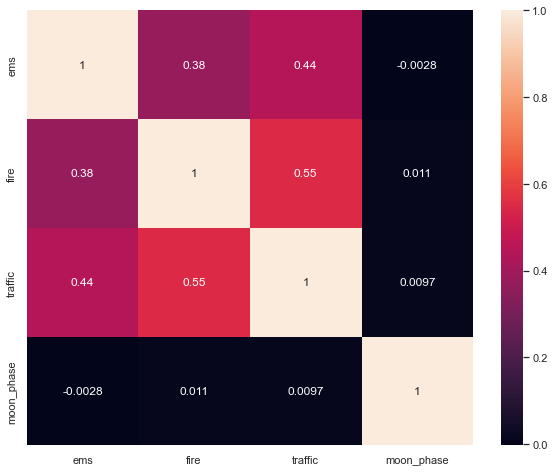

In [152]:
sns.set(rc = {'figure.figsize':(10,8)})
sns.heatmap(moon_and_calls.select_dtypes(np.number).corr(), annot=True)

*Basically no correlation visible at this point...\
   ...but we are not done yet!*

Lets take a closer look at the call data...

In [157]:
def get_hour(x):
    return x.hour

moon_and_calls['hr'] = moon_and_calls['timestamp_hr'].apply(get_hour)
moon_and_calls

,timestamp_hr,ems,fire,traffic,moon_phase,hr
0,2015-12-10 17:00:00,5,1,10,30,17
1,2015-12-10 14:00:00,0,1,0,30,14
2,2015-12-10 16:00:00,5,0,1,30,16
3,2015-12-10 15:00:00,1,0,0,30,15
4,2015-12-10 18:00:00,9,4,13,30,18
...,...,...,...,...,...,...
40541,2020-07-29 11:00:00,12,4,1,10,11
40542,2020-07-29 12:00:00,9,2,4,10,12
40543,2020-07-29 13:00:00,12,4,6,10,13
40544,2020-07-29 14:00:00,9,2,5,10,14


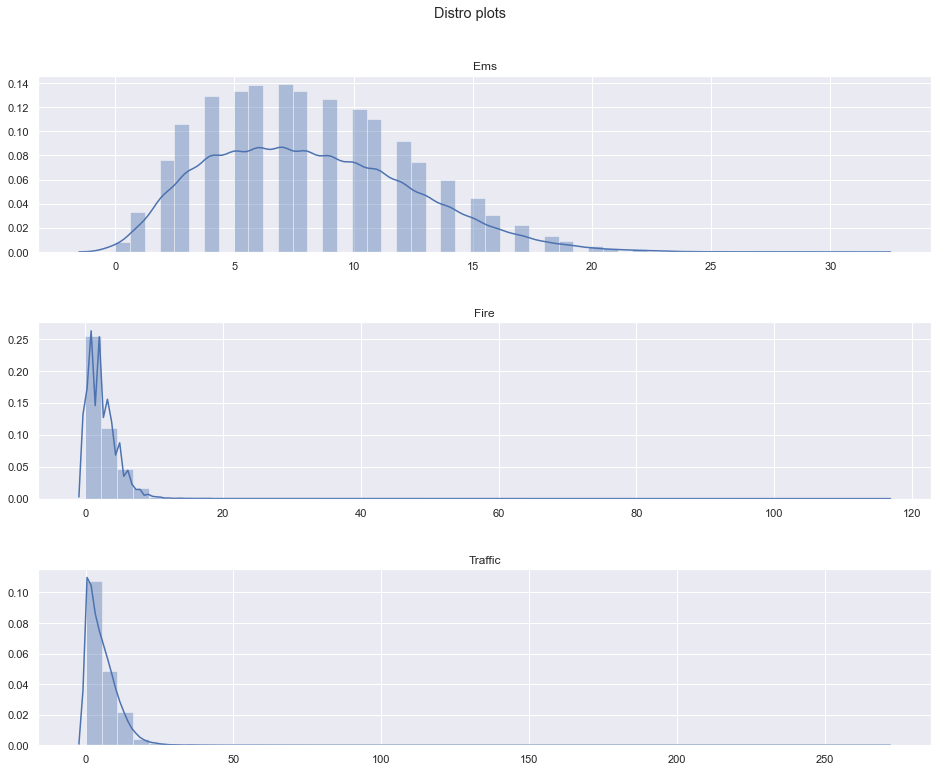

In [168]:
plot_my_distro(moon_and_calls[['ems','fire','traffic']], in_cols = 1, group_title="Distro plots")

In [286]:
# how about the volume for each hour by month

def heat_map_targets(df, mydate, targets):
    sns.set(rc = {'figure.figsize':(16,(math.ceil(len(targets))*5))})
    fig = plt.figure()
    fig.subplots_adjust(hspace=.4, wspace=0.4)
    fig.subplots_adjust(top=0.80)
    i = 1
    for c in targets: #skip customer
        ax =  fig.add_subplot(math.ceil(len(targets)), 1, i)
        i = i + 1
        hours = list(map(lambda x:x.hour,df[mydate]))
        hours = pd.DataFrame(hours, columns=['hours'])
        months = list(map(lambda x:x.month,df[mydate]))
        months = pd.DataFrame(months, columns=['months'])
        hoursandmonths = pd.concat([hours, months, df[c]],axis=1)
        hoursandmonths = hoursandmonths.groupby(['hours','months']).agg({c:np.mean})
        hoursandmonths = hoursandmonths.reset_index()
        hoursandmonths = hoursandmonths.pivot(index='months',columns='hours',values=c)
        ax = sns.heatmap(hoursandmonths)
        ax.set(title=unsnake(c))
    plt.suptitle('Cases by hour and month')
    plt.show()
    
def heat_map_targets2(df, mydate, targets):
    sns.set(rc = {'figure.figsize':(32,(math.ceil(len(targets))*5))})
    fig = plt.figure()
    fig.subplots_adjust(hspace=.4, wspace=0.4)
    fig.subplots_adjust(top=0.80)
    i = 1
    for c in targets: #skip customer
        ax =  fig.add_subplot(math.ceil(len(targets)), 1, i)
        i = i + 1
        years = list(map(lambda x:x.year,df[mydate]))
        years = pd.DataFrame(years, columns=['years'])
        day_of_year = list(map(lambda x:x.timetuple().tm_yday,df[mydate]))
        day_of_year = pd.DataFrame(day_of_year, columns=['day_of_year'])
        years_days = pd.concat([day_of_year, years, df[c]],axis=1)
        years_days = years_days.groupby(['day_of_year','years']).agg({c:np.mean})
        years_days = years_days.reset_index()
        years_days = years_days.pivot(index='years',columns='day_of_year',values=c)
        ax = sns.heatmap(years_days)
        ax.set(title=unsnake(c))
    plt.suptitle('Cases by year and day of year')
    plt.show()

320

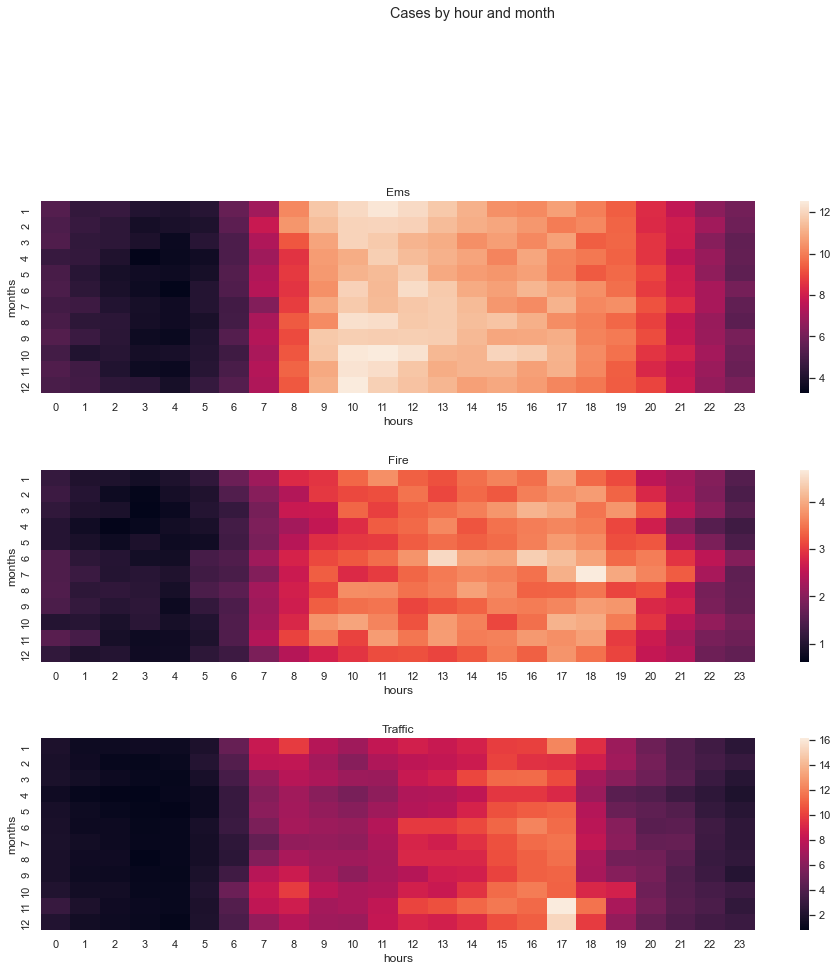

In [190]:
heat_map_targets(moon_and_calls, 'timestamp_hr', ['ems','fire','traffic'])

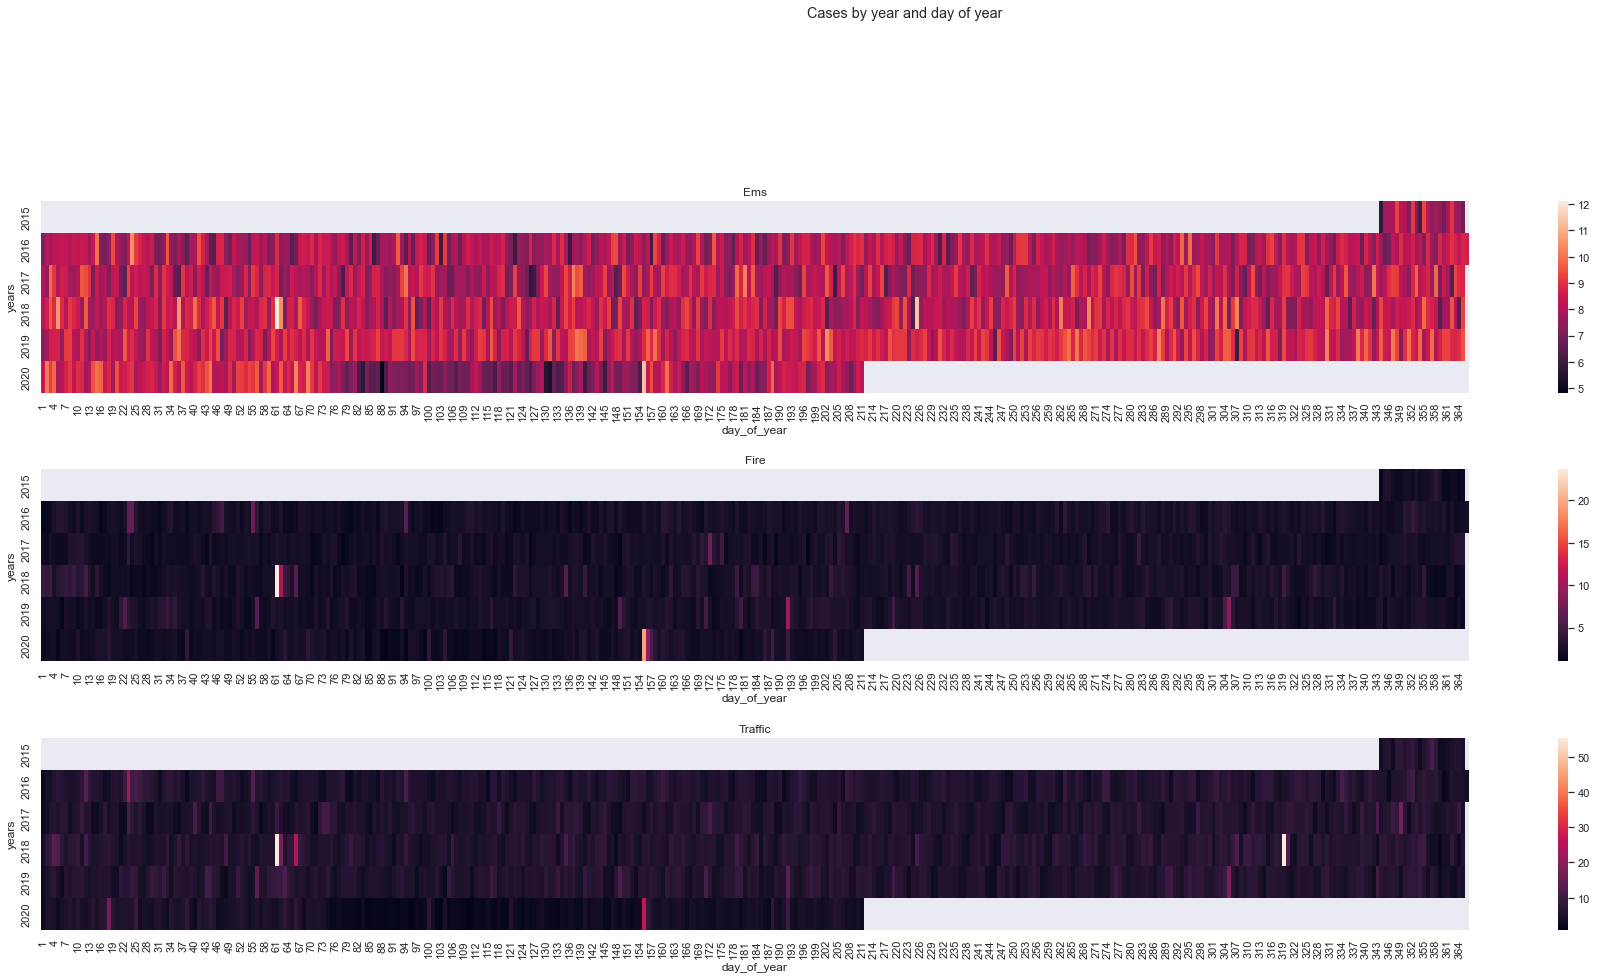

In [287]:
heat_map_targets2(moon_and_calls, 'timestamp_hr', ['ems','fire','traffic'])

**Notes:**
- Ems is pretty consistant throughout the year peaking between 10:00 and 13:00.
- Fire calls, we see during the summer months we have a slight increase but also receiving more calls until later in the day
- Traffic, not too much shift over the year, we do see some banding in the morning and then in the afternoon - which is what you might expect with rush hours.
- Was expecting to see some kind of seasonality over the years but nothing pops in our year by day of year charts.
- March 2nd (day 61) 2018, this area was impacted by a "nor'easter", a specific storm type: <a>https://en.wikipedia.org/wiki/March_1%E2%80%933,_2018_nor%27easter</a>
    - the article mentions a second nor'easter impacted a few days later hampering recovery efforts and we do see this second follow-up spike in traffic and fire.

## What if we make our moon phase more simple

In [322]:
def simple_phase(x, before=3, after=3):
    # if x == 15:
    #     return 1
    if (x >= 15-before) & (x <= 15+after):
        return 1
    else:
        return 0

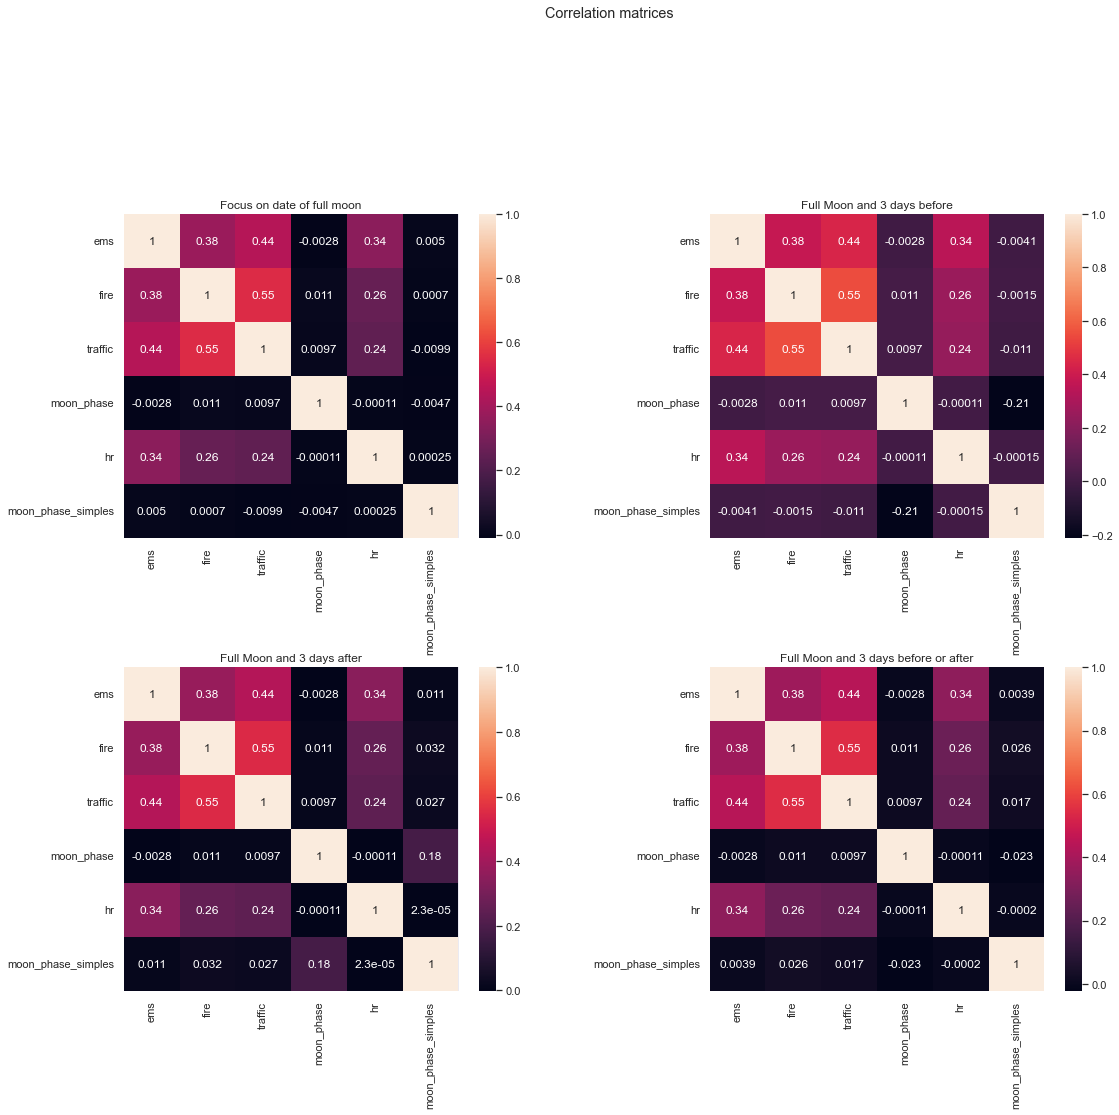

In [333]:
sns.set(rc = {'figure.figsize':(18,16)})
fig = plt.figure()
fig.subplots_adjust(hspace=.4, wspace=0.4)
fig.subplots_adjust(top=0.80)

ax =  fig.add_subplot(2, 2, 1)
moon_and_calls['moon_phase_simples'] = moon_and_calls['moon_phase'].apply(simple_phase,before=0,after=0)
ax = sns.heatmap(moon_and_calls.select_dtypes(np.number).corr(), annot=True)
ax.set(title='Focus on date of full moon')

ax =  fig.add_subplot(2, 2, 2)
moon_and_calls['moon_phase_simples'] = moon_and_calls['moon_phase'].apply(simple_phase,before=6,after=0)
ax = sns.heatmap(moon_and_calls.select_dtypes(np.number).corr(), annot=True)
ax.set(title='Full Moon and 3 days before')

ax =  fig.add_subplot(2, 2, 3)
moon_and_calls['moon_phase_simples'] = moon_and_calls['moon_phase'].apply(simple_phase,before=0,after=6)
ax = sns.heatmap(moon_and_calls.select_dtypes(np.number).corr(), annot=True)
ax.set(title='Full Moon and 3 days after')

ax =  fig.add_subplot(2, 2, 4)
moon_and_calls['moon_phase_simples'] = moon_and_calls['moon_phase'].apply(simple_phase,before=6,after=6)
ax = sns.heatmap(moon_and_calls.select_dtypes(np.number).corr(), annot=True)
ax.set(title='Full Moon and 3 days before or after')


plt.suptitle('Correlation matrices')
plt.show()

With 3 values for moon phase - still very low correlations, though it doess double for ems and fire it is slightly worse for fire related incidents but still basically zeros. We improve this slightly more when taking it further and just having 2 values for our moon phase, though this is worse if we are very strict and only set 1 for exact day of full moon.

....lets get an idea of the night hours....
via https://www.sunearthtools.com/solar/sunrise-sunset-calendar.php#top

In [241]:
city = LocationInfo("Montgomery County", "USA", "US/Eastern", 40.2290, 75.3879)
print((f"Information for {city.name}/{city.region}\n"
    f"Timezone: {city.timezone}\n"
    f"Latitude: {city.latitude:.02f}; Longitude: {city.longitude:.02f}\n"))

sunset = []
sunrise = []
sundates = []

for d in pd.date_range(start = '2015-01-01', end='2020-12-31'):
    s = sun(city.observer, date=d, tzinfo=city.timezone)
    sundates.append(d)
    sunset.append(s['sunset'].replace(second=0, microsecond=0))
    sunrise.append(s['sunrise'].replace(second=0, microsecond=0))

sun_d = {'sundates':sundates,'sunset':sunset,'sunrise':sunrise}
sun_data = pd.DataFrame(sun_d)
sun_data.tail(5)

Information for Montgomery County/USA
Timezone: US/Eastern
Latitude: 40.23; Longitude: 75.39



,sundates,sunset,sunrise
2187,2020-12-27,2020-12-27 06:39:00-05:00,2020-12-26 21:20:00-05:00
2188,2020-12-28,2020-12-28 06:39:00-05:00,2020-12-27 21:20:00-05:00
2189,2020-12-29,2020-12-29 06:40:00-05:00,2020-12-28 21:20:00-05:00
2190,2020-12-30,2020-12-30 06:41:00-05:00,2020-12-29 21:20:00-05:00
2191,2020-12-31,2020-12-31 06:42:00-05:00,2020-12-30 21:21:00-05:00


Well, that ain't right...I could just rearrange another excel I got to import but think I'll just use it to pick reasonable times where the moon being up could have some impact.
     ...goint to just look at a general filtered look at times between 19:00 and 03:00

In [242]:
moon_and_calls.head()

,timestamp_hr,ems,fire,traffic,moon_phase,hr,moon_phase_simples
0,2015-12-10 17:00:00,5,1,10,30,17,0
1,2015-12-10 14:00:00,0,1,0,30,14,0
2,2015-12-10 16:00:00,5,0,1,30,16,0
3,2015-12-10 15:00:00,1,0,0,30,15,0
4,2015-12-10 18:00:00,9,4,13,30,18,0


<AxesSubplot:>

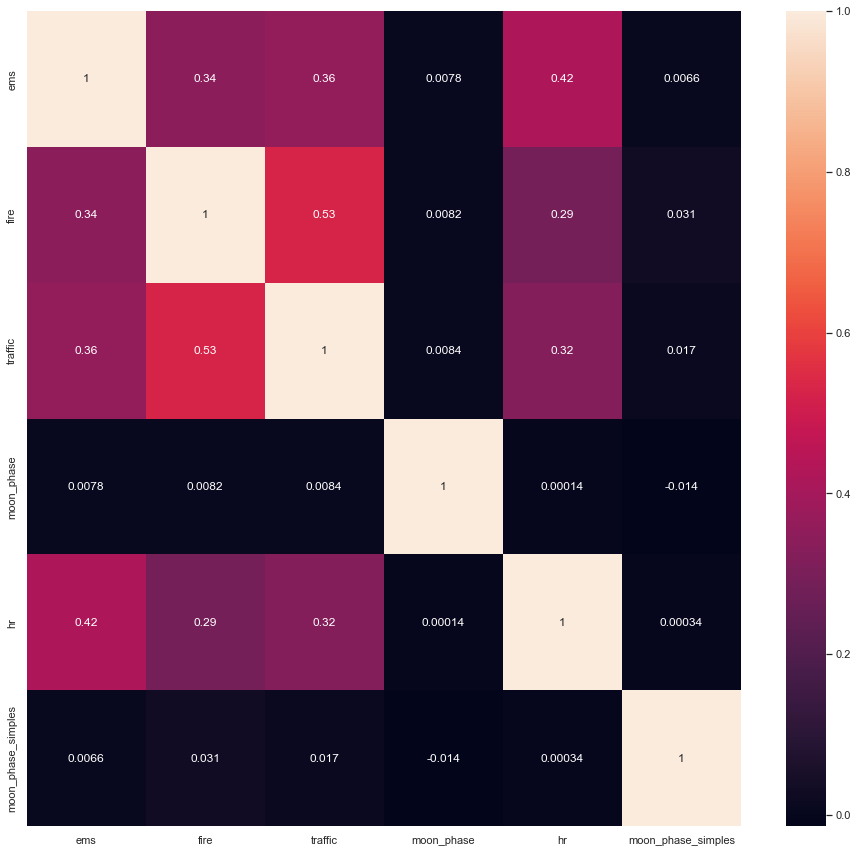

In [244]:
sns.heatmap(moon_and_calls[(moon_and_calls['hr'] >= 19) | (moon_and_calls['hr'] <= 2)].select_dtypes(np.number).corr(), annot=True)

Our correlation is still super low, I think this has to be expected....but interestingly it has still increased for all types of calls - but lets not get too excited, the change is still very minor and could just be random.

<AxesSubplot:>

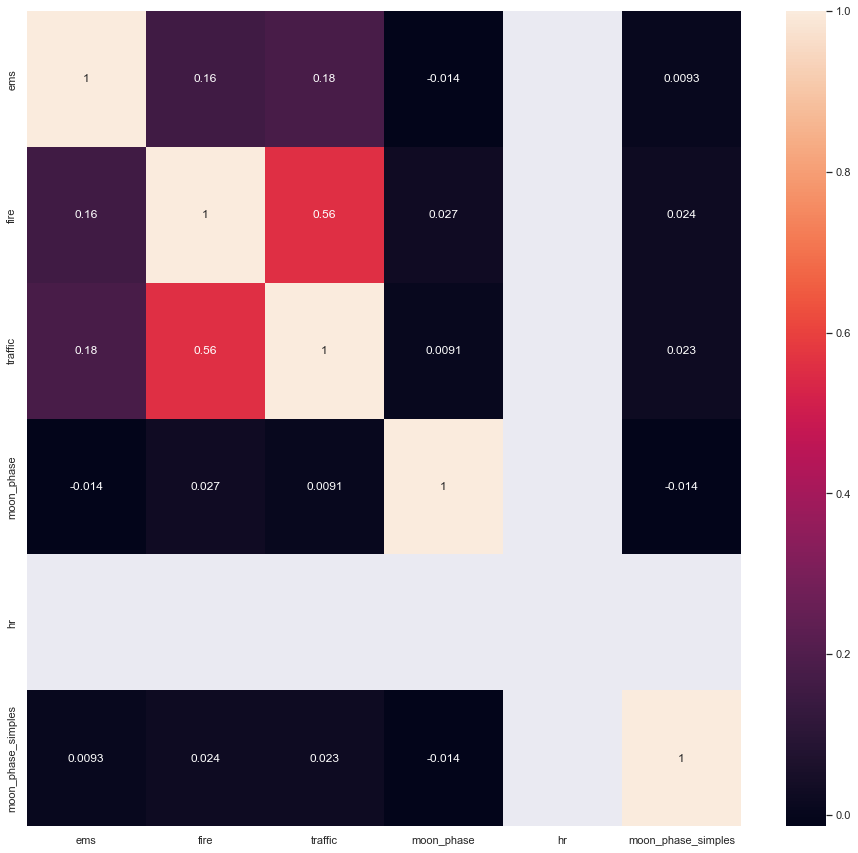

In [246]:
# lets just check the witching hour!
sns.heatmap(moon_and_calls[(moon_and_calls['hr'] == 0)].select_dtypes(np.number).corr(), annot=True)

Fire drops but EMS/Traffic did increase but are the lower correlations lets continue with between the hours of 19:00 and 03:00

## Looking into some particular categories

In [559]:
moon_and_calls2 = pd.read_sql_query("select * from moon.moon_calls2", engine)

<AxesSubplot:>

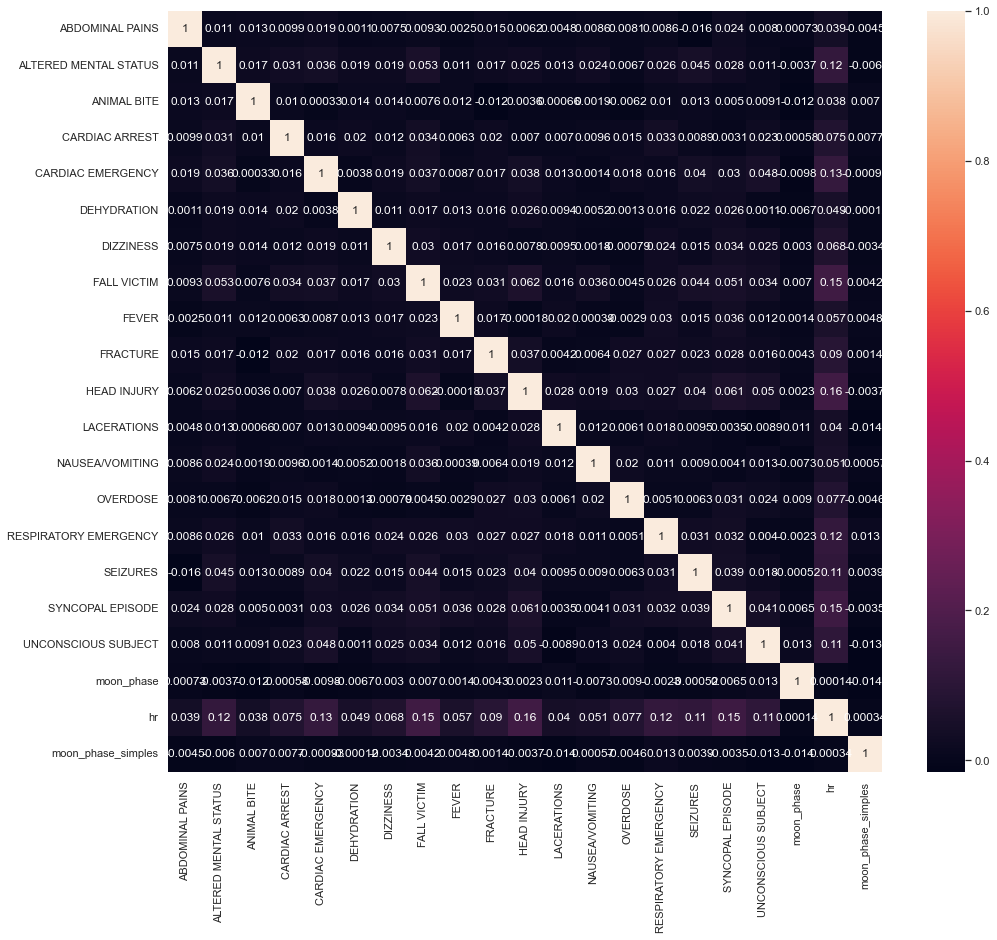

In [560]:
moon_and_calls2['hr'] = moon_and_calls2['timestamp_hr'].apply(get_hour)
moon_and_calls2['moon_phase_simples'] = moon_and_calls2['moon_phase'].apply(simple_phase)
sns.set(rc = {'figure.figsize':(16,14)})
sns.heatmap(moon_and_calls2[(moon_and_calls2['hr'] >= 19) | (moon_and_calls2['hr'] <= 2)].select_dtypes(np.number).corr(), annot=True)

*Almost choked when I first saw this as we can actually see a change in colour for the correlation...then I realised I'd switched order of hr and moon_phase_simple*

In [561]:
tmp = moon_and_calls2[(moon_and_calls2['hr'] >= 19) | (moon_and_calls2['hr'] <= 2)].select_dtypes(np.number).corr()
display(tmp[['moon_phase','moon_phase_simples']])
tmp[['moon_phase','moon_phase_simples']].to_csv('subtypes_correlations.csv')

,moon_phase,moon_phase_simples
ABDOMINAL PAINS,0.000730,-0.004519
ALTERED MENTAL STATUS,-0.003660,-0.005992
ANIMAL BITE,-0.011810,0.007050
CARDIAC ARREST,0.000584,0.007663
CARDIAC EMERGENCY,-0.009794,-0.000932
DEHYDRATION,-0.006699,-0.000125
DIZZINESS,0.002972,-0.003439
FALL VICTIM,0.007043,0.004153
FEVER,0.001370,0.004762
FRACTURE,0.004332,0.001416


*So in reality, cherry picking cases that one might associate with a full moon we do not see any correlation - not too surprising as most of these are from the 'EMS' type which was our least correlated type.*

In [290]:
moon_and_calls.to_csv('moons_and_calls.csv')

In [321]:
#OLS

## We're not really seeing any correlation though here... perhaps if we focus on sleep patterns, if we find correlation there with less sleep or lower quality sleep and such then we can infer this will have an impact on peoples behaviour.

In [300]:
sleepdata1 = pd.read_csv('sleepDay_merged.csv', parse_dates=[1]) # source: https://www.kaggle.com/arashnic/fitbit

In [298]:
sleepdata1.describe(datetime_is_numeric=True)
#sleepdata1
sleepdata1.nunique()

Id                     24
SleepDay               31
TotalSleepRecords       3
TotalMinutesAsleep    256
TotalTimeInBed        242
dtype: int64

sleepdata1 : pretty small dataset, has the right type of data but, 24 users, 31 sleep days, so only one full moon cycle to check against and low number of participants....will keep looking but could still check against this

In [305]:
sleepdata2 = pd.read_csv('sleepdata.csv', sep=';') # source: https://www.kaggle.com/danagerous/sleep-data

In [309]:
sleepdata2.describe(datetime_is_numeric=True)
sleepdata1
sleepdata2.nunique()

Start               887
End                 887
Sleep quality        79
Time in bed         229
Wake up               3
Sleep Notes          19
Heart rate           30
Activity (steps)    449
dtype: int64

sleepdata2 : pretty small dataset, has the right type of data, over longer period - 4ish years, but only a single user - might be interesting but should there be any impact of moonlight on sleep then perhaps this only effects a small % of people, a sample size of just 1 is probably not going to cut it - though would be cool with 'Wake Up' which is how they felt when they woke up.
can still check but, it is just a single user.

In [497]:
sleepdata3 = pd.read_csv('FitbitSleep(1-30-20).csv', parse_dates=[1]) # http://sites.nd.edu/nethealth/data-2/

In [315]:
display(sleepdata3.shape)
sleepdata3.nunique()

(333708, 10)

egoid                 622
dataDate             1396
timetobed            4742
timeoutofbed         4762
bedtimedur            993
minstofallasleep      151
minsafterwakeup       128
minsasleep            951
minsawake             413
Efficiency          27354
dtype: int64

apparently there is a fitbit gold mine out there with 6 billion nights of sleep in it, found analysis about it but seems the source hasn't been shared publically. though this might be a reasonable alternative.\

622 users, 333.7k sleeps, i think we can work with this.

In [317]:
sd = sleepdata3
sd.isna().sum()

egoid               0
dataDate            0
timetobed           0
timeoutofbed        2
bedtimedur          0
minstofallasleep    0
minsafterwakeup     0
minsasleep          0
minsawake           0
Efficiency          0
dtype: int64

In [318]:
sd.head()

,egoid,dataDate,timetobed,timeoutofbed,bedtimedur,minstofallasleep,minsafterwakeup,minsasleep,minsawake,Efficiency
0,44869,2015-07-28,06:25:00,10:27:00,243,0,0,232,11,0.954733
1,44869,2015-07-29,03:26:30,07:21:30,236,1,4,216,15,0.935065
2,44869,2015-07-29,12:03:30,16:44:30,282,3,0,267,12,0.956989
3,44869,2015-07-30,06:27:30,14:31:30,485,4,0,451,30,0.937630
4,44869,2015-07-31,04:40:30,06:27:30,108,0,0,100,8,0.925926


<AxesSubplot:>

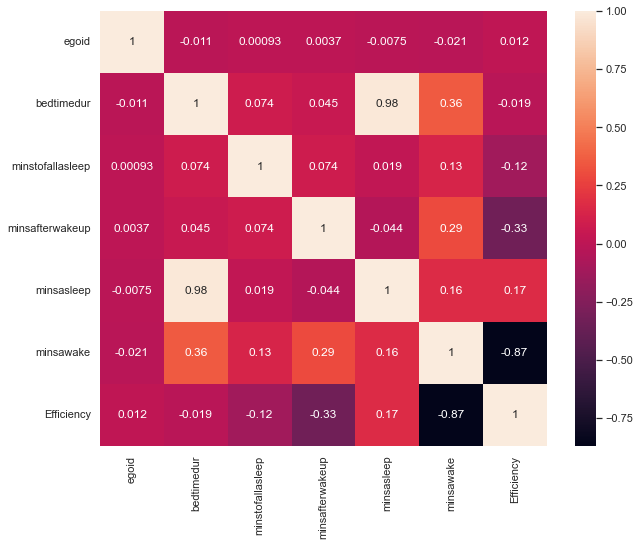

In [320]:
sns.set(rc = {'figure.figsize':(10,8)})
sns.heatmap(sd.select_dtypes(np.number).corr(), annot=True)

Cleaning this up:
Idealy I'd like to have 1 sleep for 1 night, so if someone sleeps for 6 hours then another 45 minutes soon after, count that as one sleep
Also per date...people going to bed just after midnight and then just before, would mean two records for 1 day and no record for next day.

Other than that, which is going to be a bit of a challenge the data is pretty clean, we do have a couple of nulls for getting out of bed, we might not use that column though or if we want to keep it can drop those rows / perhaps calculate them base on other items

## Cleaning sleep

In [334]:
sd

,egoid,dataDate,timetobed,timeoutofbed,bedtimedur,minstofallasleep,minsafterwakeup,minsasleep,minsawake,Efficiency
0,44869,2015-07-28,06:25:00,10:27:00,243,0,0,232,11,0.954733
1,44869,2015-07-29,03:26:30,07:21:30,236,1,4,216,15,0.935065
2,44869,2015-07-29,12:03:30,16:44:30,282,3,0,267,12,0.956989
3,44869,2015-07-30,06:27:30,14:31:30,485,4,0,451,30,0.937630
4,44869,2015-07-31,04:40:30,06:27:30,108,0,0,100,8,0.925926
...,...,...,...,...,...,...,...,...,...,...
333703,35925,2017-11-13,23:45:00,09:15:00,571,0,0,533,38,0.933450
333704,35925,2017-11-16,23:16:30,08:20:30,545,0,1,489,55,0.898897
333705,35925,2017-11-26,04:19:00,08:43:00,265,6,1,249,9,0.965116
333706,35925,2017-12-17,17:55:30,19:11:30,77,2,3,70,2,0.972222


how many 'naps' or random sleeps are we catching here rather than the main sleep for a day

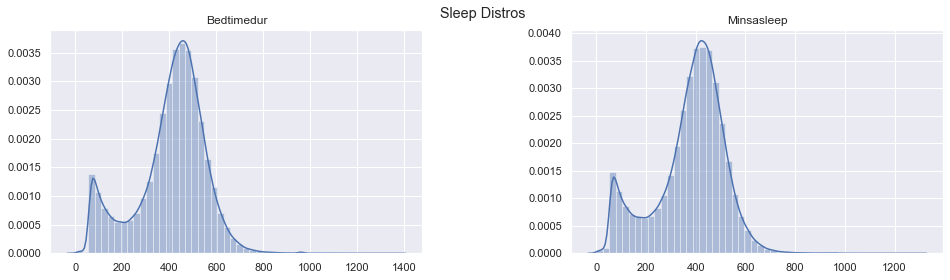

In [349]:
plot_my_distro(sd[['bedtimedur','minsasleep']], in_cols=2, group_title="Sleep Distros")

In [512]:
# so rather than trying to push late sleeps into a certain date and such can we take a simple approach of just grouping up on user and date, is that reasonable?
sd_grouped = sd[['egoid','dataDate','bedtimedur','minsasleep']].groupby(by=['egoid','dataDate']).agg({'bedtimedur':'sum','minsasleep':'sum'})
sd_grouped = sd_grouped.reset_index()
sd_grouped['efficiency'] = sd_grouped['minsasleep'] / sd_grouped['bedtimedur']
sd_grouped

,egoid,dataDate,bedtimedur,minsasleep,efficiency
0,10237,2015-08-04,477,426,0.893082
1,10237,2015-08-05,504,463,0.918651
2,10237,2015-08-06,498,454,0.911647
3,10237,2015-08-07,641,594,0.926677
4,10237,2015-08-08,523,492,0.940727
...,...,...,...,...,...
297353,99978,2019-05-08,415,397,0.956627
297354,99978,2019-05-09,447,431,0.964206
297355,99978,2019-05-11,505,481,0.952475
297356,99978,2019-05-12,482,447,0.927386


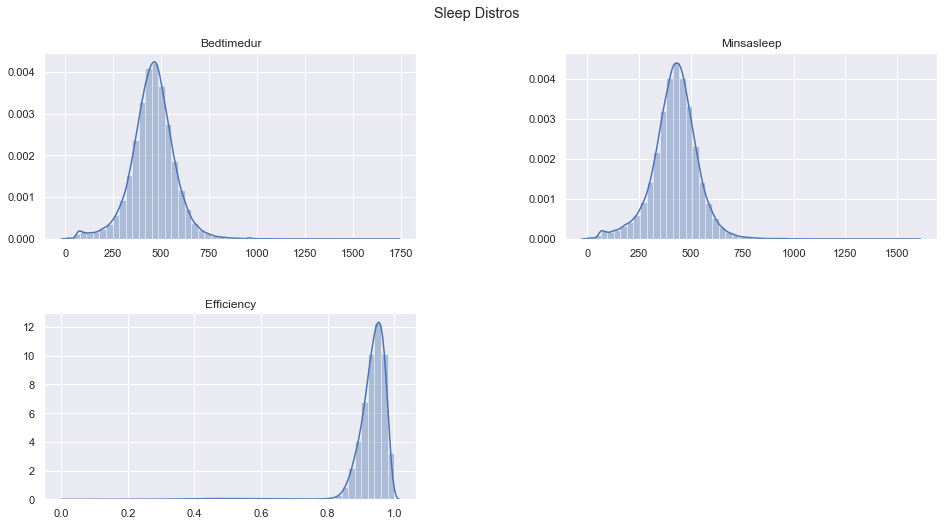

In [514]:
plot_my_distro(sd_grouped[['bedtimedur','minsasleep','efficiency']], in_cols=2, group_title="Sleep Distros")

In [352]:
# So this feels reasonable to work with, perhaps we should exclude the more extreme values though
# Not 100% sure on that though so...lets do both.

In [515]:
def moonphase2(x):
    lp = 2551443
    now = datetime(x.year,x.month,x.day,20,35,0)
    new_moon = datetime(1970, 1, 7, 20, 35, 0)
    phase = ((now - new_moon).total_seconds()) % lp
    return math.floor(phase /(24*3600)) + 1

sd_grouped['moon_phase'] = sd_grouped['dataDate'].apply(moonphase2)

In [517]:
def adjust_moon_phase(x):  # what if our 'high' point being in the middle is throwing us off since phase is 1-30 and 15 is our full moon, lets make it 15 is the highest value and before and after drops off
    if x <= 15:
        return x
    else:
        return 30-x

display(sd_grouped[['bedtimedur','minsasleep','efficiency','moon_phase']].corr())
#sns.heatmap(sd.select_dtypes(np.number).corr(), annot=True)

sd_grouped['moon_phase_simples'] = sd_grouped['moon_phase'].apply(simple_phase,before=3,after=3)
display(sd_grouped[['bedtimedur','minsasleep','efficiency','moon_phase','moon_phase_simples']].corr())

sd_grouped['moon_phase_adj'] = sd_grouped['moon_phase'].apply(adjust_moon_phase)

sd_grouped['moon_phase_simples'] = sd_grouped['moon_phase'].apply(simple_phase,before=3,after=3)
display(sd_grouped[['bedtimedur','minsasleep','efficiency','moon_phase','moon_phase_simples','moon_phase_adj']].corr())

sd_grouped['moon_phase_simples'] = sd_grouped['moon_phase'].apply(simple_phase,before=3,after=0)
display(sd_grouped[['bedtimedur','minsasleep','efficiency','moon_phase','moon_phase_simples','moon_phase_adj']].corr())

sd_grouped['moon_phase_simples'] = sd_grouped['moon_phase'].apply(simple_phase,before=0,after=3)
display(sd_grouped[['bedtimedur','minsasleep','efficiency','moon_phase','moon_phase_simples','moon_phase_adj']].corr())

sd_grouped['moon_phase_simples'] = sd_grouped['moon_phase'].apply(simple_phase,before=0,after=0)
display(sd_grouped[['bedtimedur','minsasleep','efficiency','moon_phase','moon_phase_simples','moon_phase_adj']].corr())

sd_grouped['moon_phase_simples'] = sd_grouped['moon_phase'].apply(simple_phase,before=6,after=6)
display(sd_grouped[['bedtimedur','minsasleep','efficiency','moon_phase','moon_phase_simples','moon_phase_adj']].corr())

,bedtimedur,minsasleep,efficiency,moon_phase
bedtimedur,1.000000,0.960319,0.001703,0.002518
minsasleep,0.960319,1.000000,0.267179,0.002468
efficiency,0.001703,0.267179,1.000000,-0.000694
moon_phase,0.002518,0.002468,-0.000694,1.000000


,bedtimedur,minsasleep,efficiency,moon_phase,moon_phase_simples
bedtimedur,1.000000,0.960319,0.001703,0.002518,-0.003545
minsasleep,0.960319,1.000000,0.267179,0.002468,-0.002762
efficiency,0.001703,0.267179,1.000000,-0.000694,0.000614
moon_phase,0.002518,0.002468,-0.000694,1.000000,-0.016130
moon_phase_simples,-0.003545,-0.002762,0.000614,-0.016130,1.000000


,bedtimedur,minsasleep,efficiency,moon_phase,moon_phase_simples,moon_phase_adj
bedtimedur,1.000000,0.960319,0.001703,0.002518,-0.003545,-0.001217
minsasleep,0.960319,1.000000,0.267179,0.002468,-0.002762,-0.000004
efficiency,0.001703,0.267179,1.000000,-0.000694,0.000614,0.002457
moon_phase,0.002518,0.002468,-0.000694,1.000000,-0.016130,-0.057055
moon_phase_simples,-0.003545,-0.002762,0.000614,-0.016130,1.000000,0.739131
moon_phase_adj,-0.001217,-0.000004,0.002457,-0.057055,0.739131,1.000000


,bedtimedur,minsasleep,efficiency,moon_phase,moon_phase_simples,moon_phase_adj
bedtimedur,1.000000,0.960319,0.001703,0.002518,-0.006366,-0.001217
minsasleep,0.960319,1.000000,0.267179,0.002468,-0.005054,-0.000004
efficiency,0.001703,0.267179,1.000000,-0.000694,0.003110,0.002457
moon_phase,0.002518,0.002468,-0.000694,1.000000,-0.081414,-0.057055
moon_phase_simples,-0.006366,-0.005054,0.003110,-0.081414,1.000000,0.545411
moon_phase_adj,-0.001217,-0.000004,0.002457,-0.057055,0.545411,1.000000


,bedtimedur,minsasleep,efficiency,moon_phase,moon_phase_simples,moon_phase_adj
bedtimedur,1.000000,0.960319,0.001703,0.002518,0.000349,-0.001217
minsasleep,0.960319,1.000000,0.267179,0.002468,0.000497,-0.000004
efficiency,0.001703,0.267179,1.000000,-0.000694,-0.001158,0.002457
moon_phase,0.002518,0.002468,-0.000694,1.000000,0.058801,-0.057055
moon_phase_simples,0.000349,0.000497,-0.001158,0.058801,1.000000,0.543761
moon_phase_adj,-0.001217,-0.000004,0.002457,-0.057055,0.543761,1.000000


,bedtimedur,minsasleep,efficiency,moon_phase,moon_phase_simples,moon_phase_adj
bedtimedur,1.000000,0.960319,0.001703,0.002518,-0.003070,-0.001217
minsasleep,0.960319,1.000000,0.267179,0.002468,-0.002144,-0.000004
efficiency,0.001703,0.267179,1.000000,-0.000694,0.002260,0.002457
moon_phase,0.002518,0.002468,-0.000694,1.000000,-0.005239,-0.057055
moon_phase_simples,-0.003070,-0.002144,0.002260,-0.005239,1.000000,0.323573
moon_phase_adj,-0.001217,-0.000004,0.002457,-0.057055,0.323573,1.000000


,bedtimedur,minsasleep,efficiency,moon_phase,moon_phase_simples,moon_phase_adj
bedtimedur,1.000000,0.960319,0.001703,0.002518,0.000663,-0.001217
minsasleep,0.960319,1.000000,0.267179,0.002468,0.001844,-0.000004
efficiency,0.001703,0.267179,1.000000,-0.000694,0.002759,0.002457
moon_phase,0.002518,0.002468,-0.000694,1.000000,-0.027777,-0.057055
moon_phase_simples,0.000663,0.001844,0.002759,-0.027777,1.000000,0.860309
moon_phase_adj,-0.001217,-0.000004,0.002457,-0.057055,0.860309,1.000000


So we don't have any correlation here either, though an interesting note what little correlation is showing when we are focused in on the full moon or a short range around it, it is negeative which is at least in the right direction for having less sleep during a full moon. It's just too low though for it to be statistically significant.

In [380]:
# take another pass this time removing the extreme values
# another thing to consider is when we are focused in on a full moon or not, or even a short period around a full moon or not we must expect some imbalance there
# though i think this is only problematic if we tried to model and predict - and it shouldn't be such an issue for correlation

In [518]:
sd_grouped.describe()

,egoid,bedtimedur,minsasleep,efficiency,moon_phase,moon_phase_simples,moon_phase_adj
count,297358.000000,297358.000000,297358.000000,297358.000000,297358.000000,297358.000000,297358.000000
mean,56572.228718,454.868488,422.807111,0.929486,15.237125,0.441818,7.639757
std,25781.485259,114.727410,110.213736,0.067701,8.509204,0.496604,4.276614
min,10237.000000,8.000000,1.000000,0.016949,1.000000,0.000000,0.000000
25%,33785.000000,392.000000,364.000000,0.915367,8.000000,0.000000,4.000000
50%,57325.000000,458.000000,428.000000,0.941320,15.000000,0.000000,8.000000
75%,79341.000000,522.000000,488.000000,0.961643,23.000000,1.000000,11.000000
max,99978.000000,1716.000000,1587.000000,1.000000,30.000000,1.000000,15.000000


In [383]:
# so as we have mins asleep going from 1 to 1587 (which is actually more hours than there is in a day...), lets focus only on reasonable durations of sleep and see if there is movement there.
# we could use the quantiles and take our 'whisker' ranges iqr*1.5 but I'm just going to limit it when our results show between 5 and 9 hours sleep

In [547]:
display(sd_grouped.shape)
display(sd_grouped[(sd_grouped['minsasleep'] >= 300) & (sd_grouped['minsasleep'] <= 540)].shape)
display(sd_grouped[(sd_grouped['minsasleep'] < 300) | (sd_grouped['minsasleep'] > 540)].shape)
# another thought: if we explore this data set a bit more, we could check for variance in weekdays and weekends
# we can expect people will have more sleep at the weekend in general so we might want to factor that in (full moon on weekend / full moon on weekday)

sd_filtered = sd_grouped[(sd_grouped['minsasleep'] >= 300) & (sd_grouped['minsasleep'] <= 540)]
# the 666 (dun dun dunnn) hundred columns

(297358, 10)

(230672, 10)

(66686, 10)

In [548]:
display(sd_grouped.shape)
display(sd_filtered[sd_filtered['efficiency'] >= 0.8].shape)
display(sd_filtered[sd_filtered['efficiency'] < 0.8].shape)
sd_filtered = sd_filtered[sd_filtered['efficiency'] >= 0.8]
sd_filtered.describe()

(297358, 10)

(229714, 10)

(958, 10)

,egoid,bedtimedur,minsasleep,efficiency,moon_phase,moon_phase_simples,moon_phase_adj,is_weekend
count,229714.000000,229714.000000,229714.000000,229714.000000,229714.000000,229714.000000,229714.000000,229714.000000
mean,56436.667935,454.703849,425.894203,0.937432,15.254299,0.034421,7.641424,0.264942
std,25775.351799,64.939767,60.065674,0.032504,8.506696,0.182309,4.275472,0.441304
min,10237.000000,300.000000,300.000000,0.800000,1.000000,0.000000,0.000000,0.000000
25%,33740.000000,406.000000,380.000000,0.917485,8.000000,0.000000,4.000000,0.000000
50%,56805.000000,456.000000,428.000000,0.942222,15.000000,0.000000,8.000000,0.000000
75%,79341.000000,504.000000,473.000000,0.961995,23.000000,0.000000,11.000000,1.000000
max,99978.000000,663.000000,540.000000,1.000000,30.000000,1.000000,15.000000,1.000000


In [549]:
sd_filtered['moon_phase_simples'] = sd_filtered['moon_phase'].apply(simple_phase,before=3,after=3)
display(sd_filtered[['bedtimedur','minsasleep','efficiency','moon_phase','moon_phase_simples','moon_phase_adj']].corr())

,bedtimedur,minsasleep,efficiency,moon_phase,moon_phase_simples,moon_phase_adj
bedtimedur,1.000000,0.968951,-0.170501,0.004925,-0.003809,-0.003703
minsasleep,0.968951,1.000000,0.075802,0.003964,-0.002919,-0.002824
efficiency,-0.170501,0.075802,1.000000,-0.004021,0.003688,0.003491
moon_phase,0.004925,0.003964,-0.004021,1.000000,-0.018089,-0.060572
moon_phase_simples,-0.003809,-0.002919,0.003688,-0.018089,1.000000,0.739189
moon_phase_adj,-0.003703,-0.002824,0.003491,-0.060572,0.739189,1.000000


In [396]:
#ok, so we can get a intsy winsy teeny weeny increase with our filtered data - but changing the period we look at we might get a decrease, so just within error ranges

In [397]:
#lets explore weekday vs weekend sleep...

In [550]:
def get_weekend(x):
    if x.weekday() in (5,6):
        return 1
    else:
        return 0
    
def get_day(x):
    return x.day_name()
    
sd_filtered['day_name'] = sd_filtered['dataDate'].apply(get_day)
sd_filtered['is_weekend'] = sd_filtered['dataDate'].apply(get_weekend)
sd_filtered.head(20)

,egoid,dataDate,bedtimedur,minsasleep,efficiency,moon_phase,moon_phase_simples,moon_phase_adj,day_name,is_weekend
0,10237,2015-08-04,477,426,0.893082,20,0,10,Tuesday,0
1,10237,2015-08-05,504,463,0.918651,21,0,9,Wednesday,0
2,10237,2015-08-06,498,454,0.911647,22,0,8,Thursday,0
4,10237,2015-08-08,523,492,0.940727,24,0,6,Saturday,1
5,10237,2015-08-09,504,480,0.952381,25,0,5,Sunday,1
6,10237,2015-08-10,499,474,0.949900,26,0,4,Monday,0
7,10237,2015-08-11,511,473,0.925636,27,0,3,Tuesday,0
8,10237,2015-08-12,426,386,0.906103,28,0,2,Wednesday,0
9,10237,2015-08-13,447,407,0.910515,29,0,1,Thursday,0
10,10237,2015-08-14,352,344,0.977273,30,0,0,Friday,0


In [531]:
display(sd_filtered.groupby(by=['day_name']).agg({'bedtimedur':'mean','minsasleep':'mean'}).reset_index())
sd_filtered.groupby(by=['is_weekend']).agg({'bedtimedur':'mean','minsasleep':'mean'}).reset_index()

,day_name,bedtimedur,minsasleep
0,Friday,442.734075,414.596294
1,Monday,448.661753,420.193641
2,Saturday,471.451440,442.056721
3,Sunday,477.047746,447.107658
4,Thursday,450.128278,421.666454
5,Tuesday,452.004552,423.400417
6,Wednesday,446.488260,418.436392


,is_weekend,bedtimedur,minsasleep
0,0,448.011338,419.666743
1,1,474.235002,444.569020


In [535]:
# that was filtered, what if we look before we filtered
sd_grouped['day_name'] = sd_grouped['dataDate'].apply(get_day)
sd_grouped['is_weekend'] = sd_grouped['dataDate'].apply(get_weekend)

display(sd_grouped.groupby(by=['day_name']).agg({'bedtimedur':'mean','minsasleep':'mean'}).reset_index())
sd_grouped.groupby(by=['is_weekend']).agg({'bedtimedur':'mean','minsasleep':'mean'}).reset_index()

,day_name,bedtimedur,minsasleep
0,Friday,442.213348,410.798838
1,Monday,448.042885,416.456525
2,Saturday,470.858105,437.929568
3,Sunday,476.470099,443.024629
4,Thursday,449.809285,418.015274
5,Tuesday,451.760379,419.815066
6,Wednesday,446.142163,414.752512


,is_weekend,bedtimedur,minsasleep
0,0,447.600823,415.974495
1,1,473.648511,440.462943


In [427]:
# so yes, generally people have more sleep at the weekend than during the week.
# sunday being the day people have the most sleep and friday being the day people have the least sleep

In [428]:
# so to account for the variance of the day, how about we check a full moon by the day it lands on... or at least if it is a weekend or not

In [538]:
# rather than plotting correlations lets just view the amount of sleep on average people have for weekday / weekend and if it is a full moon or not...
# keep it simple, stupid
# no, i said keep it simple stupid
sd_grouped['moon_phase_simples'] = sd_grouped['moon_phase'].apply(simple_phase,before=0,after=0)
sleep_amounts = sd_grouped.groupby(by=['is_weekend','moon_phase_simples']).agg({'bedtimedur':'mean','minsasleep':'mean', 'egoid':'size'}).reset_index()
sleep_amounts.columns = ['is_weekend','moon_phase_simples','bedtimedur','minsasleep','row_counts']
sleep_amounts.insert(4,'efficiency',sleep_amounts['minsasleep']/sleep_amounts['bedtimedur'],allow_duplicates=False)
display(sleep_amounts)

sd_filtered['moon_phase_simples'] = sd_filtered['moon_phase'].apply(simple_phase,before=0,after=0)
sleep_amounts = sd_filtered.groupby(by=['is_weekend','moon_phase_simples']).agg({'bedtimedur':'mean','minsasleep':'mean', 'egoid':'size'}).reset_index()
sleep_amounts.columns = ['is_weekend','moon_phase_simples','bedtimedur','minsasleep','row_counts']
sleep_amounts.insert(4,'efficiency',sleep_amounts['minsasleep']/sleep_amounts['bedtimedur'],allow_duplicates=False)
display(sleep_amounts)

,is_weekend,moon_phase_simples,bedtimedur,minsasleep,efficiency,row_counts
0,0,0,447.809893,416.154407,0.929310,207341
1,0,1,441.452057,410.683262,0.930301,7050
2,1,0,473.431741,440.238240,0.929887,79865
3,1,1,479.229529,446.248227,0.931178,3102


,is_weekend,moon_phase_simples,bedtimedur,minsasleep,efficiency,row_counts
0,0,0,448.210998,419.841752,0.936706,203447
1,0,1,442.137941,414.518508,0.937532,6916
2,1,0,474.017223,444.354722,0.937423,78267
3,1,1,479.836346,450.080841,0.937988,3043


In [446]:
# in our unfiltered data we do have an average of 6 minutes less on weekdays with a full moon than without, though when we filter out
# the extreme values we just see a 2 minute variance - which is similar to the variance we see between days of the week

# ...and then we also see the reverse for the weekends where people get 6 and 5 more minutes sleep during a full moon

# not shown but also checked when not directly a full moon but in that ball park and the variance is actually less then

In [447]:
# should i be concerned over how i just grouped up the time slept for each day...possibly but nahhh

<AxesSubplot:xlabel='moon_phase', ylabel='minsasleep'>

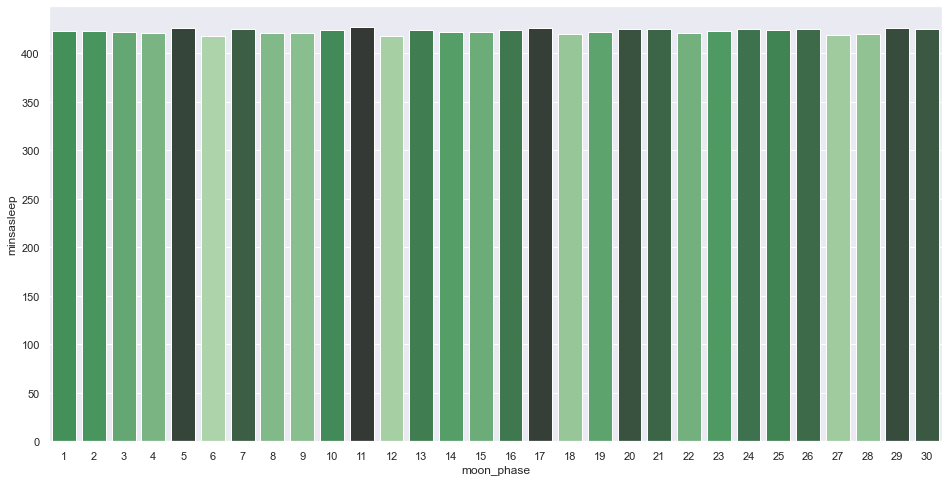

In [539]:
# lets plot a couple of charts for mins asleep for each moonphase, 15=full moon

sd_grouped['moon_phase_simples'] = sd_grouped['moon_phase'].apply(simple_phase,before=0,after=0)
sleep_amounts = sd_grouped.groupby(by=['moon_phase']).agg({'bedtimedur':'mean','minsasleep':'mean', 'egoid':'size'}).reset_index()
sleep_amounts.columns = ['moon_phase','bedtimedur','minsasleep','row_counts']

pal = sns.color_palette("Greens_d", len(sleep_amounts))
rank = (-sleep_amounts['minsasleep']).argsort().argsort()
rank
sns.barplot(x='moon_phase',y='minsasleep',data=sleep_amounts, palette=np.array(pal[::-1])[rank])


<AxesSubplot:xlabel='moon_phase', ylabel='minsasleep'>

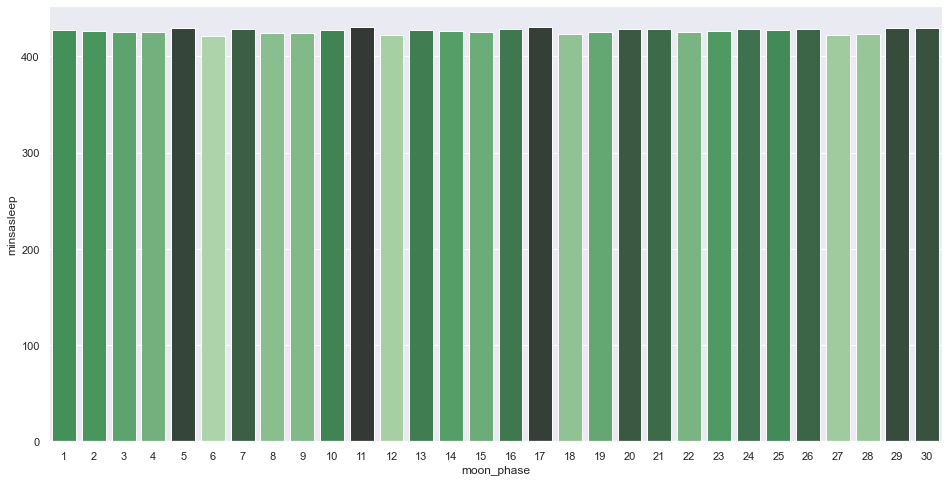

In [540]:
sd_filtered['moon_phase_simples'] = sd_filtered['moon_phase'].apply(simple_phase,before=0,after=0)
sleep_amounts = sd_filtered.groupby(by=['moon_phase']).agg({'bedtimedur':'mean','minsasleep':'mean', 'egoid':'size'}).reset_index()
sleep_amounts.columns = ['moon_phase','bedtimedur','minsasleep','row_counts']

pal = sns.color_palette("Greens_d", len(sleep_amounts))
rank = (-sleep_amounts['minsasleep']).argsort().argsort()
rank
sns.barplot(x='moon_phase',y='minsasleep',data=sleep_amounts, palette=np.array(pal[::-1])[rank])


<AxesSubplot:xlabel='moon_phase', ylabel='minsasleep'>

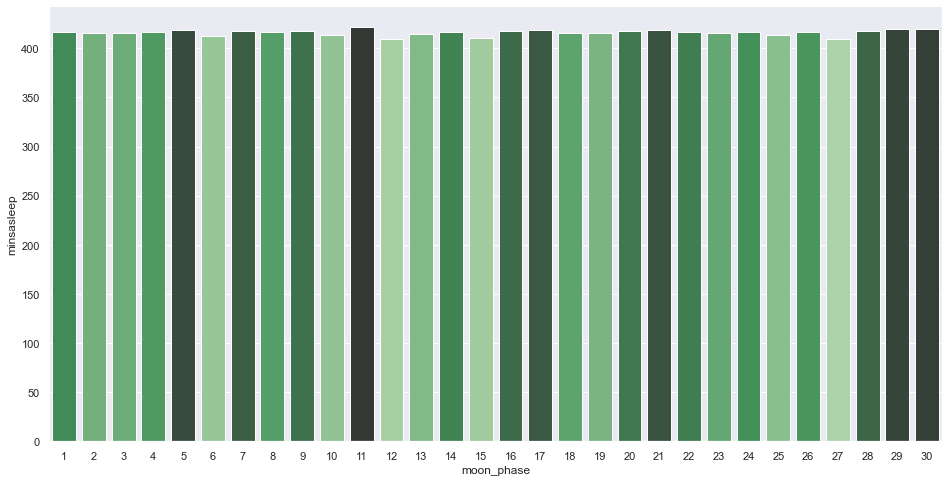

In [541]:
# just for weekdays...in our unfiltered set which showed the biggest difference cos i'm grasping at straws...
sd_grouped['moon_phase_simples'] = sd_grouped['moon_phase'].apply(simple_phase,before=0,after=0)
sleep_amounts = sd_grouped[sd_grouped['is_weekend']==0].groupby(by=['moon_phase']).agg({'bedtimedur':'mean','minsasleep':'mean', 'egoid':'size'}).reset_index()
sleep_amounts.columns = ['moon_phase','bedtimedur','minsasleep','row_counts']

pal = sns.color_palette("Greens_d", len(sleep_amounts))
rank = (-sleep_amounts['minsasleep']).argsort().argsort()
rank
sns.barplot(x='moon_phase',y='minsasleep',data=sleep_amounts, palette=np.array(pal[::-1])[rank])

In [488]:
# so here we do have day 15, our full moon is indeed a lighter day for sleep, though surrounded by above average days, and is comparible to other seeming random days in the cycle so overall it seems pretty random

### Conclusion

We have found no significant evidence to support changes in behaviour directly via calls to emergency services or indirectly via sleep patterns.

Although theorizing on the light effect of a full moon impacting sleep seems sound, the amount of light is still very low and in the modern world with so light polution and other sources of light then these will likely far outweigh the impact of the moon, if indeed there is any impact. Perhaps if we had sleep pattern data from pre-elecricity or pre-candle times, perhaps we would see an impact.

In [ ]:
#creating a particular view of the data for a particular vis - which didn't end up working so well, found alternative that achieve the effect I was after that also didn't involve taking all our days, and duplicating them over a 180 day moving period.
night_moon_calls = pd.read_sql_query("select * from moon.night_moon_calls", engine)

In [496]:
night_moon_calls.to_csv('night_moon_calls.csv', index=False)

,day_number,calldate,daily_calls,moon_phase
0,0,2016-06-07,88,3
1,0,2016-06-06,85,2
2,0,2016-06-05,82,1
3,0,2016-06-04,108,29
4,0,2016-06-03,83,28
...,...,...,...,...
290319,1691,2020-07-28,72,9
290320,1691,2020-07-27,96,8
290321,1692,2020-07-29,21,10
290322,1692,2020-07-28,72,9


In [553]:
sd_filtered.to_csv('fitbit_sleep_data_cleaned.csv')